# Optotagged FTCs
here we try to create a native python tuning plot, and then try to determine differencese between putative
inhibitory interneurons and pyramidal cells defined by optotagging


In [9]:

import pathlib as pl
import joblib as jl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nems_lbhb.baphy_experiment import  BAPHYExperiment
from nems.epoch import epoch_names_matching
from src.visualization.fancy_plots import  subplots_sqr
from src.root_path import root_path



#### Loads FTC data
right now form a single file
to do, load based on DF querries for neruons

In [10]:
# set general parameters for loading and plotting
parmfile = '/auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m'
rasterfs = 1000 # in samps per sec
onset_dur = 0.05 # in sec
offset_dur = 0.05 # in sec
options ={'recache': False, 'resp': True, 'rasterfs': rasterfs, 'stim':False}


In [11]:
print('loading data ...')
# get a recording somehow, TODO is there a way of doing this by cell and batch
dirty_cache_path = root_path / 'data' / 'test_rec_for_ftc_tuning_delete_me'
if not dirty_cache_path.exists():
    print('cache not existant, loading recording')
    if not dirty_cache_path.parent.exists():
        dirty_cache_path.parent.mkdir(parents=True)
    manager = BAPHYExperiment(parmfile=parmfile)
    rec = manager.get_recording(**options)
    jl.dump(rec, dirty_cache_path)
else:
    print('loading recordign from cache')
    rec = jl.load(dirty_cache_path)

print('done')

loading data ...
loading recordign from cache
done


#### works with a whole site at a time
get the response of a neuron to all different tones, sorts the dictionary of tone responses
into an array of shape Repetitions x Neurons x ToneFreq x Time

then parses the important parts of the response, I.E Onset (50ms) Ofsset (50ms) and full duration
(100ms)



In [12]:
print('parsing data ...')
# once you have the recording extract the raw data
epochs = rec.epochs
ep_names = epochs.name.unique
tone_eps = epoch_names_matching(epochs,'\ASTIM_\d*\Z')
tone_eps.sort(key= lambda x: int(x.split('_')[1]))

resp = rec['resp'].rasterize()
raster = resp.extract_epochs(tone_eps)

R, N, T = raster[tone_eps[0]].shape # repetitions, Neurons, time
S = len(tone_eps)
site_raster = np.empty((R, N, S, T))

for ii, key in enumerate(tone_eps):
    site_raster[:, :, ii, :] = raster[key]

# we need the pre stim silence and sound duration to get different parts of the response parsed out
PreStimSilence = resp.extract_epoch('PreStimSilence')
spont_rate = PreStimSilence.mean(axis=(0, -1)) * rasterfs
pre_stim_bins = PreStimSilence.shape[-1]
post_stim_bins = resp.extract_epoch('PostStimSilence').shape[-1]

onset_raster = site_raster[..., pre_stim_bins : pre_stim_bins + int(onset_dur * rasterfs)]
offset_raster = site_raster[..., T-post_stim_bins : T - post_stim_bins + int(offset_dur * rasterfs)]
sustained_raster = site_raster[..., pre_stim_bins :T-post_stim_bins]

raster_parts = {'onset': onset_raster, 'sustained': sustained_raster, 'offset': offset_raster}

print('done')

parsing data ...
done


#### calculates tuning
mean across repetitions and time (for the time chunck selected, e.g. onset)
standard error of the mean over the same numbers

In [13]:
# defines  PSHT and MES to plot ToDo: simplify in kdictionary comprehensions??
parts_tuning = dict()
parts_sem = dict()
for part, rast in raster_parts.items():
    # for tuning curves take the mean across repetitions and timepoints
    parts_tuning[part] = rast.mean(axis=(0,-1)) * rasterfs
    parts_sem[part]  = rast.std(axis=(0, -1)) / np.sqrt(R + T) * rasterfs

#### Plots one example cell
the quality of the plot has been confirmed by comparing with its baphy remote equivalent
there are minor discrepancies but nothing to be worried about.

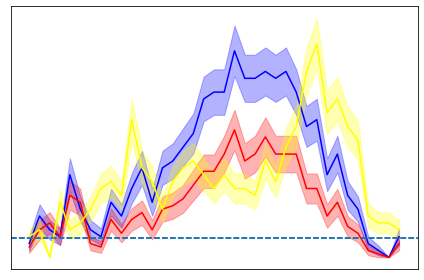

In [14]:
# ploting
selected_cells = [resp.chans[-1]]

x = [int(t.split('_')[1]) for t in tone_eps]
fig, axes = subplots_sqr(len(selected_cells), sharex=True, sharey=False)
colors = {'onset':'blue', 'sustained':'red',  'offset':'yellow'}

for ax, cellid in zip(axes, selected_cells):
    cc = resp.chans.index(cellid)
    for part in parts_tuning.keys():
        color = colors[part]
        line = parts_tuning[part][cc,:]
        upper = line + parts_sem[part][cc,:]
        lower = line - parts_sem[part][cc,:]
        spont = spont_rate[cc]

        _ = ax.plot(x, line, color=color, label=part)
        _ = ax.fill_between(x, lower, upper, color=color, alpha=0.3)
        _ = ax.axhline(spont, linestyle='--')

        ax.set_xscale('log')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        # ax.set_title(cellid)

fig.tight_layout()


## now to quantify
try to align tuning curves based on their peak,
see if there is any difference between subsets, for now arbitarlily generated





